# Scalar Bilevel ROF Single Gaussian (SG)
We will solve the following bilevel problem

$$
\min_\lambda \|\hat{u}-\bar{u}\|^2 + \beta\lambda^2\\
\text{s.t. } \hat{u} = arg\min_u \frac{1}{2}\|u-f\|^2+\lambda\|\mathbb{K} u\|_{2,1} 
$$

We will use a small dataset of one sample contaminated with gaussian noise to learn the optimal parameter for the ROF image denoising model.

In [5]:
include("../../src/BilevelImagingParameterLearning.jl")
using .BilevelImagingParameterLearning

┌ Info: Precompiling AbstractOperators [d9c5613a-d543-52d8-9afd-8f241a8c3f1c]
└ @ Base loading.jl:1242
┌ Info: Recompiling stale cache file /Users/dvillacis/.julia/compiled/v1.2/ProximalOperators/ez37h.ji for ProximalOperators [a725b495-10eb-56fe-b38b-717eba820537]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/dvillacis/.julia/compiled/v1.2/ProximalAlgorithms/JnB3M.ji for ProximalAlgorithms [140ffc9f-1907-541a-a177-7475e0a401e9]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/dvillacis/.julia/compiled/v1.2/StructuredOptimization/Ap5Gs.ji for StructuredOptimization [46cd3e9d-64ff-517d-a929-236bc1a1fc9d]
└ @ Base loading.jl:1240


In [8]:
using Random, Images, TestImages, ImageQualityIndexes, StructuredOptimization, AbstractOperators
Random.seed!(123);

┌ Info: Precompiling ImageQualityIndexes [2996bd0c-7a13-11e9-2da2-2f5ce47296a9]
└ @ Base loading.jl:1242


┌ Info: Recompiling stale cache file /Users/dvillacis/.julia/compiled/v1.2/QuartzImageIO/n8vDP.ji for QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1240


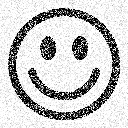

In [9]:
# Noisy image
u = datasetimage("1_smiley_noisy","/Users/dvillacis/workspace/BilevelImagingParameterLearning.jl/src/datasets/smiley_dataset")
u[u .< 0] .= 0. # Make sure pixels are in range
u[u .> 1] .= 1.
Gray.(u)

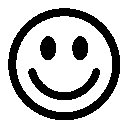

In [10]:
# Ground truth
ut = datasetimage("1_smiley_original","/Users/dvillacis/workspace/BilevelImagingParameterLearning.jl/src/datasets/smiley_dataset")
ut[ut .< 0] .= 0. # Make sure pixels are in range
ut[ut .> 1] .= 1.
Gray.(ut)

In [11]:
println("SSIM: ",ssim(u,ut))
println("PSNR: ",psnr(u,ut))

SSIM: 0.41487045600825345
PSNR: 13.07757184046984


## Bilevel Cost Function
First, we will plot the cost function to see the form it has for this particular problem

In [12]:
# Lower Level Solver
function lower_level_solver(lambda,Y,V,U)
    @minimize ls(-V'*U+Y) + conj(lambda*norm(U,2,1,2)) with ForwardBackward(tol = 1e-3, gamma = 1/8, fast = true) 
    return Gray.(-V'*(~U)+Y)
end

# Upper level cost
function upper_level_cost(ut,u,beta,lambda)
    return 0.5*norm(vcat((u-ut)...)) + beta*lambda^2
end

upper_level_cost (generic function with 1 method)

In [13]:
K = Variation(size(u)) # Define the finite differences gradient operator
U = Variable(size(K,1)...)
beta = 0.01;

In [15]:
using Distributed

lambda_range = 0.01:0.01:5;

costs = Float64[]
ssim_val = Float64[]
@distributed for lambda in lambda_range
    U_hat = lower_level_solver(lambda,u,K,U)
    push!(costs,upper_level_cost(ut,U_hat,beta,lambda))
    push!(ssim_val,ssim(U_hat,ut))
end

Task (done) @0x0000000131385210

In [16]:
# Saving generated data
using JLD
save("smiley_scalar_rof_cost.jld", "lambda", lambda_range, "costs", costs, "ssim_val",ssim_val)

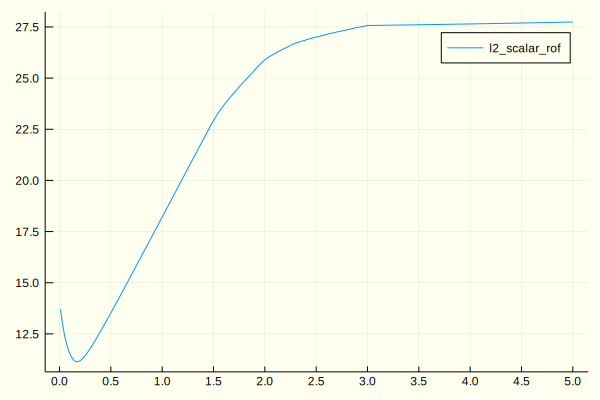

In [17]:
using Plots
d = load("smiley_scalar_rof_cost.jld")
plot(d["lambda"],d["costs"],label="l2_scalar_rof",xticks = 0:0.5:5, background_color = :ivory)

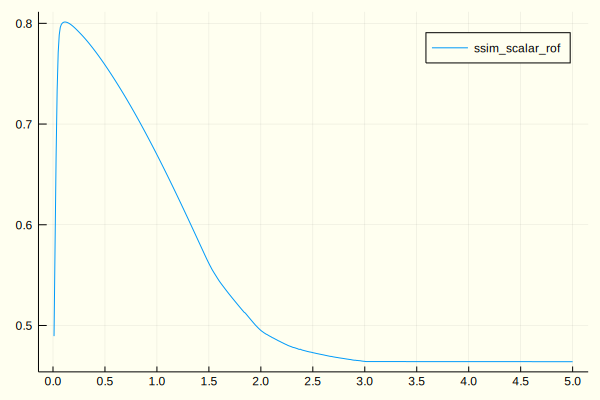

In [18]:
plot(d["lambda"],d["ssim_val"],label="ssim_scalar_rof",xticks = 0:0.5:5, background_color = :ivory)

## Solving Bilevel Problem
We will define a numerical strategy based on an inexact Trust Region method to solve the bilevel problem. First, we need to define a gradient calculation

In [43]:
include("gradient_solver.jl")

gradient_solver (generic function with 1 method)

In [44]:
nabla = gradient_matrix(size(u))
@time grad,ch = gradient_solver(u,ut,0.1,K,nabla)

SparseVector{Float64,Int64}
SparseVector{Float64,Int64}


MethodError: MethodError: no method matching *(::SparseVector{Float64,Int64}, ::SparseVector{Float64,Int64})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  *(!Matched::Adjoint{#s617,#s616} where #s616<:LinearAlgebra.AbstractTriangular where #s617, ::AbstractArray{T,1} where T) at /Users/sabae/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.2/LinearAlgebra/src/triangular.jl:1850
  *(!Matched::Adjoint{#s617,#s616} where #s616<:(Union{Hermitian{T,S}, Hermitian{Complex{T},S}, Symmetric{T,S}} where S where T<:Real) where #s617, ::AbstractArray{T,1} where T) at /Users/sabae/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.2/LinearAlgebra/src/symmetric.jl:457
  ...

In [49]:
println(typeof(ch["resnom"]))


MethodError: MethodError: no method matching getindex(::ConvergenceHistory{true,Nothing}, ::String)
Closest candidates are:
  getindex(::ConvergenceHistory, !Matched::Symbol) at /Users/dvillacis/.julia/packages/IterativeSolvers/QuajJ/src/history.jl:107
  getindex(::ConvergenceHistory, !Matched::Symbol, !Matched::Any...) at /Users/dvillacis/.julia/packages/IterativeSolvers/QuajJ/src/history.jl:108

In [ ]:
plot(ch["resnorm"],label="error_norm",xticks = 0:0.5:5, background_color = :ivory)

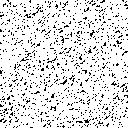

In [24]:
Ku = K*u
norms = sqrt.(sum(Ku.^2, dims=2))
norms = reshape(norms,128,128) # Inactive set
Gray.(norms .> 1e-3)

In [22]:
pwd()

"/Users/dvillacis/workspace/BilevelImagingParameterLearning.jl/demo/bilevel_scalar_rof"

In [23]:
import Pkg; Pkg.add("IterativeSolvers")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %Fetching: [==================================>      ]  84.4 % Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
  [42fd0dbc] + IterativeSolvers v0.8.1
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
